In [ ]:
!pip install -q bresenham

In [ ]:
import csv
import re
import math
import numpy as np
import numba as nb
import ast
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from bresenham import bresenham

In [ ]:
def log_odds(prob):
  return np.log(prob / (1 - prob))

def retrieve_prob(log_odds):
  return 1 - 1 /(1 + np.exp(log_odds))

In [ ]:
from skimage.draw import line as draw_line

class GridMap:
    def __init__(self, map_size, resolution, prob_free, prob_occ):
        self.prob_free = log_odds(prob_free)
        self.prob_occ = log_odds(prob_occ)
        self.TRESHOLD_P_FREE = 0.3
        self.TRESHOLD_P_OCC = 0.6
        self.resolution = resolution
        self.map = np.full(map_size, fill_value=log_odds(0.5))

    def update(self, pose, points):
        zero = (pose // self.resolution).astype(np.int32)
        pixels = (points // self.resolution).astype(np.int32)

        for x, y in pixels:
            rr, cc = draw_line(zero[0], zero[1], x, y)
            for r, c in zip(rr, cc):
                self.map[r, c] += self.prob_free
            self.map[x, y] += self.prob_occ

    def prob_to_map(self):
        return retrieve_prob(self.map)

    def MLE(self):
        for x in range(self.map.shape[0]):
            for y in range(self.map.shape[1]):
                if self.map[x, y] < log_odds(self.TRESHOLD_P_FREE):
                    self.map[x, y] = log_odds(0.01)
                elif self.map[x, y] > log_odds(self.TRESHOLD_P_OCC):
                    self.map[x, y] = log_odds(0.99)
                else:
                    self.map[x, y] = log_odds(0.5)

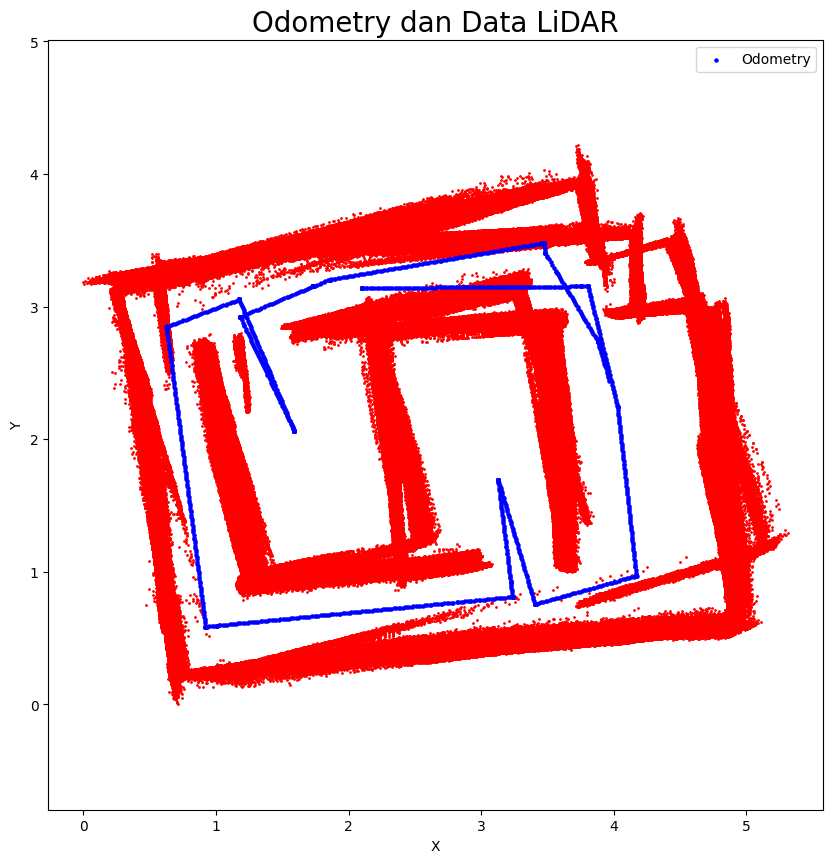

In [ ]:
def polar_to_cartesian(r, theta):
    """
    Convert polar coordinates to Cartesian coordinates.
    r: radius (distance)
    theta: angle (in radians)
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

# file_path = "/content/drive/MyDrive/data/Skripsi/20-05|13:09:51.csv" # room in unbounded
file_path = "/content/drive/MyDrive/data/Skripsi/22-05|10:06:54.csv" # room in bounded
# file_path = "/content/drive/MyDrive/data/Skripsi/22-05|12:07:08.csv" # rectangular
# file_path = "/content/drive/MyDrive/data/Skripsi/26-05|16:54:06.csv" # diamond


pose_l = []
angle_min = []
angle_max = []
angle_increment = []
range_min = []
range_max = []
ranges = []
intensities = []
cartesian = []

with open(file_path, mode='r') as file:
    csv_reader = csv.DictReader(file)
    for i,row in enumerate(csv_reader):
            pose_value = ast.literal_eval(row['pose'])
            pose_list = list(pose_value)
            pose_l.append(pose_list)

            angle_min.append(float(row['angle_min']))
            angle_max.append(float(row['angle_max']))
            angle_increment.append(float(row['angle_increment']))
            range_min.append(float(row['range_min']))
            range_max.append(float(row['range_max']))

            ranges.append(np.array([float(x) for x in row['ranges'].strip('[]').split(',')]))
            intensities.append(np.array([float(x) for x in row['intensities'].strip('[]').split(',')]))

pose = np.array(pose_l)
angle_min = np.array(angle_min)
angle_max = np.array(angle_max)
angle_increment = np.array(angle_increment)
range_min = np.array(range_min)
range_max = np.array(range_max)

correspond_intensities = []

for i in range(len(ranges)):
    inten = []
    temp = []
    for j in range(len(ranges[i])):
        if range_min[i] < ranges[i][j] < range_max[i]:
            angle = angle_min[i] + (j * angle_increment[i])
            x, y = polar_to_cartesian(ranges[i][j], angle)
            temp.append(np.array([x, y]))
            inten.append(np.array(intensities[i][j]))
    cartesian.append(temp)
    correspond_intensities.append(inten)

import numpy as np

def transform_lasers_with_pose(pose, lasers):
    transformed_lasers = []
    for i in range(len(pose)):
        px, py, theta = pose[i]
        laser_points = np.array(lasers[i])
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        transformed_points = np.zeros_like(laser_points)
        for j in range(laser_points.shape[0]):
            lx, ly = laser_points[j]
            x_prime = px + lx * cos_theta - ly * sin_theta
            y_prime = py + lx * sin_theta + ly * cos_theta
            transformed_points[j] = [x_prime, y_prime]
        transformed_lasers.append(transformed_points)
    return transformed_lasers

transformed_lasers = transform_lasers_with_pose(pose, cartesian[:pose.shape[0]])

def visualize_transformed_lasers(transformed_lasers, pose):
    all_points = np.vstack(transformed_lasers)
    min_x, min_y = np.min(all_points[:, 0]), np.min(all_points[:, 1])
    translation = np.array([-min_x, -min_y, 0])
    plt.figure(figsize=(10, 10))
    shifted_lasers = []
    for scan in transformed_lasers:
        shifted_scan = scan + translation[:2]
        shifted_lasers.append(np.array(shifted_scan))
        plt.scatter(shifted_scan[:, 0], shifted_scan[:, 1], s=1, c='red')

    shifted_pose = pose + translation
    plt.scatter(shifted_pose.T[0], shifted_pose.T[1], c='blue', label="Odometry", s=5)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Odometry dan Data LiDAR', fontsize=20)
    plt.axis('equal')
    plt.legend()
    plt.show()
    return all_points, shifted_lasers, shifted_pose

all_points, shifted_lasers, shifted_pose = visualize_transformed_lasers(transformed_lasers[:1800], pose[:1800])

In [ ]:
def calc_grid_map_config(ox, oy, xy_resolution, EXTEND_AREA):
    """
    Calculates the size, and the maximum distances according to the the
    measurement center
    """
    min_x = round(min(ox) - EXTEND_AREA / 2.0)
    min_y = round(min(oy) - EXTEND_AREA / 2.0)
    max_x = round(max(ox) + EXTEND_AREA / 2.0)
    max_y = round(max(oy) + EXTEND_AREA / 2.0)
    xw = int(round((max_x - min_x) / xy_resolution))
    yw = int(round((max_y - min_y) / xy_resolution))
    print("The grid map is ", xw, "x", yw, ".")
    return xw, yw

In [ ]:
from tqdm import tqdm

map_res = 0.05
xw, yw = calc_grid_map_config(all_points[:, 0], all_points[:, 1], map_res, 0.5)
map_size = (107, 85) #
occ = GridMap(map_size, map_res, 0.45, 0.9)

for pose_ex, points in tqdm(zip(shifted_pose, shifted_lasers)):
  scan2map = occ.update(pose_ex[:2], points)

occ.MLE()
map = occ.prob_to_map()

The grid map is  100 x 80 .


1800it [00:38, 46.24it/s]


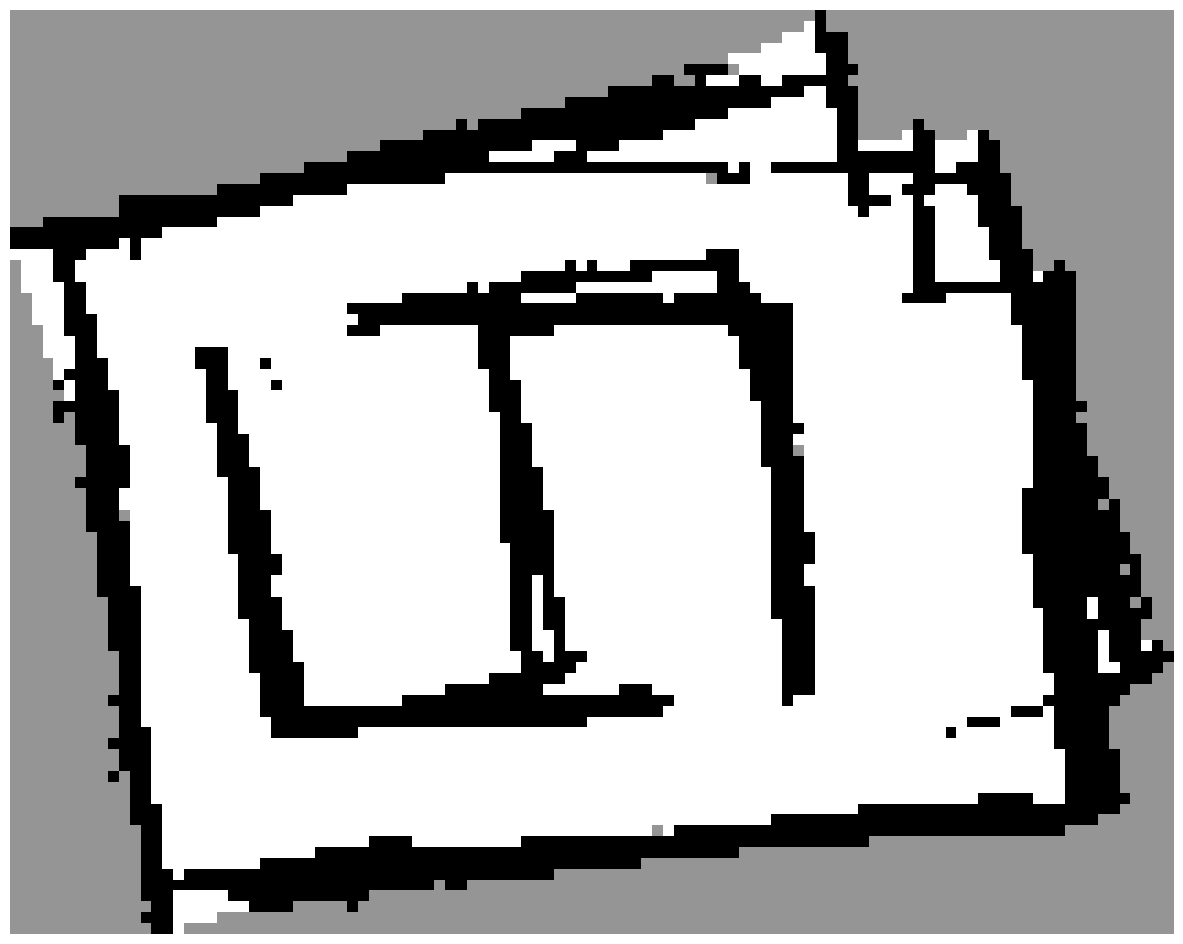

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
plt.imshow(map.T[::-1], cmap="Greys")
plt.xlabel("X, m")
plt.ylabel("Y, m")
plt.grid(False)
plt.axis("off")
plt.savefig("/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_odom.jpeg", bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
diamond = "/content/drive/MyDrive/data/Skripsi/Proccessed/DIAMOND/slam_0.05_0.05_10_1601_0.05_dist:0.1.csv"
rectangular = "/content/drive/MyDrive/data/Skripsi/Proccessed/RECTANGULAR/slam_0.05_0.05_10_1180_0.05_dist:0.1.csv"
room = "/content/drive/MyDrive/data/Skripsi/Proccessed/ROOM BOUNDED/PGO/slam_0.05_0.05_10_1800_0.05_dist:0.1.csv"
room_plicp = "/content/drive/MyDrive/data/Skripsi/Proccessed/PLICP_Only/slam_0_0_10_1800_0.05_dist:0.1_PLICP_ONLY_room.csv"

Detected encoding: ascii


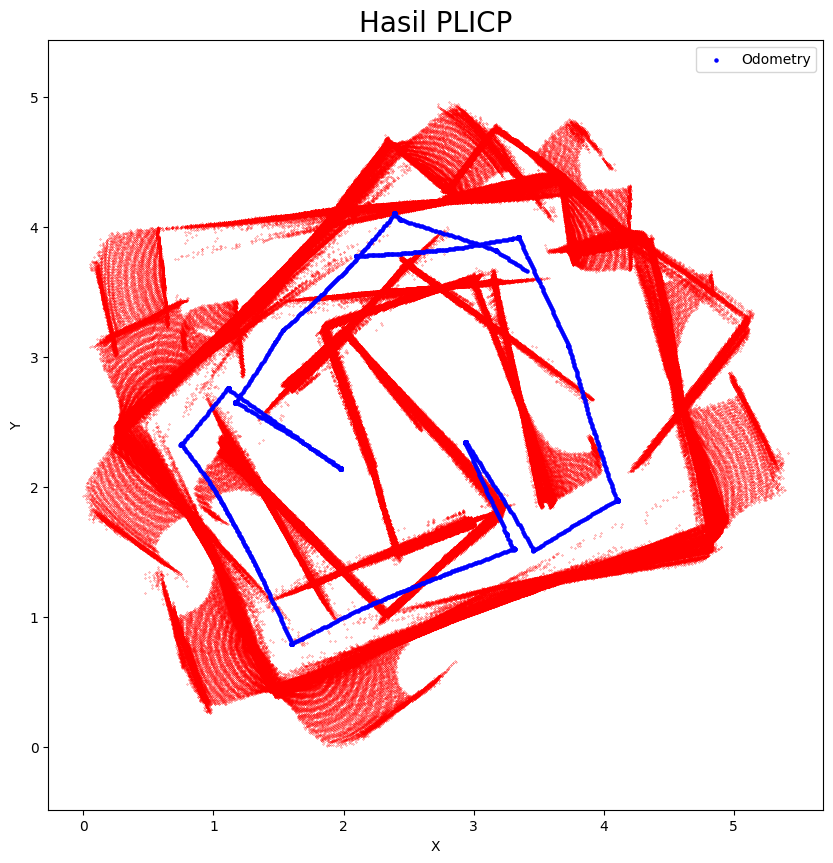

<Figure size 640x480 with 0 Axes>

In [ ]:
import chardet
room_plicp_poses = []
room_plicp_point_clouds = []

# Function to detect file encoding
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']

encoding = detect_encoding(room_plicp)
print(f"Detected encoding: {encoding}")

with open(room_plicp, mode='r', encoding=encoding) as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        pose = ast.literal_eval(row[0])
        point_cloud = ast.literal_eval(row[1])
        room_plicp_poses.append(pose)
        room_plicp_point_clouds.append(np.array(point_cloud))

room_plicp_poses = np.array(room_plicp_poses)

def visualize_transformed_lasers(transformed_lasers, pose, angle_deg):
    angle_rad = np.deg2rad(angle_deg)

    rotation = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    rotated_lasers = [scan @ rotation.T for scan in transformed_lasers]
    all_points = np.vstack(rotated_lasers)

    min_x, min_y = np.min(all_points[:, 0]), np.min(all_points[:, 1])
    translation = np.array([-min_x, -min_y])

    plt.figure(figsize=(10, 10))
    shifted_lasers = []

    for scan in rotated_lasers:
        shifted_scan = scan + translation
        shifted_lasers.append(shifted_scan)
        plt.scatter(shifted_scan[:, 0], shifted_scan[:, 1], s=0.05, c='red')

    rotated_pose = pose @ rotation.T
    shifted_pose = rotated_pose + translation

    plt.scatter(shifted_pose[:, 0], shifted_pose[:, 1], c='blue', label="Odometry", s=5)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Hasil PLICP', fontsize=20)
    plt.axis('equal')
    plt.legend()
    plt.show()
    plt.savefig("/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_plicp_pred_pc.jpeg", bbox_inches='tight', pad_inches=0)

    return all_points, shifted_lasers, shifted_pose

room_plicp_all_points, room_plicp_shifted_lasers, room_plicp_shifted_pose = visualize_transformed_lasers(room_plicp_point_clouds, room_plicp_poses, 0)

In [ ]:
from tqdm import tqdm

map_res = 0.05
xw, yw = calc_grid_map_config(room_plicp_all_points[:, 0], room_plicp_all_points[:, 1], map_res, 0.5)
map_size = (109, 100)
occ = GridMap(map_size, map_res, 0.45, 0.9)

for pose_ex, points in tqdm(zip(room_plicp_shifted_pose, room_plicp_shifted_lasers)):
  scan2map = occ.update(pose_ex[:2], points)

occ.MLE()
map_room_plicp = occ.prob_to_map()

The grid map is  120 x 100 .


1458it [00:36, 40.39it/s]


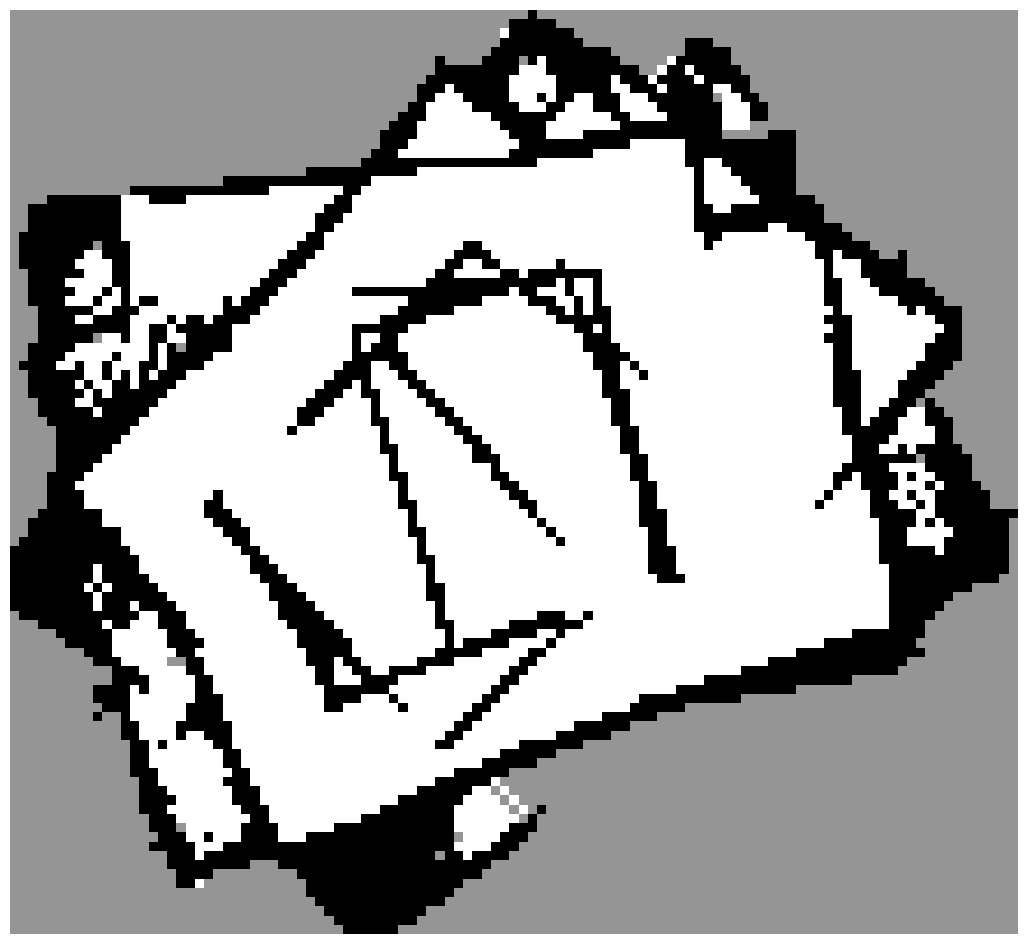

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
plt.imshow(map_room_plicp.T[::-1], cmap="Greys")
# plt.plot(shifted_pose[:, 0], shifted_pose[:, 1])
plt.xlabel("X, m")
plt.ylabel("Y, m")
plt.grid("off")
plt.axis("off")
plt.savefig("/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_plicp_pred.jpeg", bbox_inches='tight', pad_inches=0)
plt.show()

Detected encoding: ascii


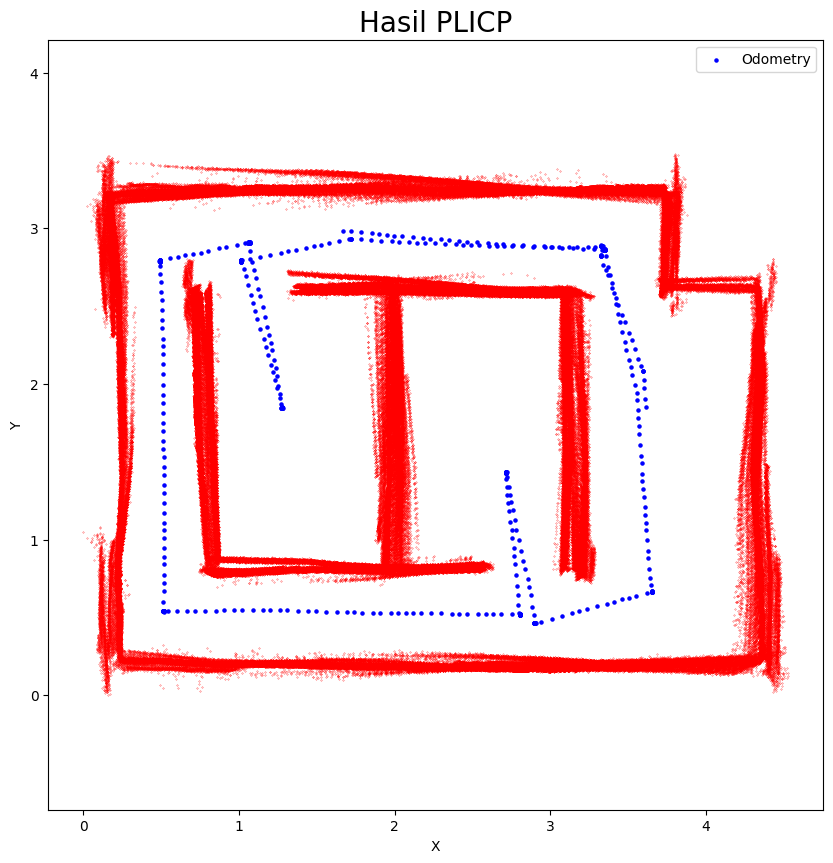

In [ ]:
import chardet
room_poses = []
room_point_clouds = []

# Function to detect file encoding
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']

encoding = detect_encoding(room)
print(f"Detected encoding: {encoding}")

with open(room, mode='r', encoding=encoding) as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        pose = ast.literal_eval(row[0])
        point_cloud = ast.literal_eval(row[1])
        room_poses.append(pose)
        room_point_clouds.append(np.array(point_cloud))

room_poses = np.array(room_poses)

def visualize_transformed_lasers(transformed_lasers, pose, angle_deg):
    angle_rad = np.deg2rad(angle_deg)

    rotation = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    rotated_lasers = [scan @ rotation.T for scan in transformed_lasers]
    all_points = np.vstack(rotated_lasers)

    min_x, min_y = np.min(all_points[:, 0]), np.min(all_points[:, 1])
    translation = np.array([-min_x, -min_y])

    plt.figure(figsize=(10, 10))
    shifted_lasers = []

    for scan in rotated_lasers:
        shifted_scan = scan + translation
        shifted_lasers.append(shifted_scan)
        plt.scatter(shifted_scan[:, 0], shifted_scan[:, 1], s=0.05, c='red')

    rotated_pose = pose @ rotation.T
    shifted_pose = rotated_pose + translation

    plt.scatter(shifted_pose[:, 0], shifted_pose[:, 1], c='blue', label="Odometry", s=5)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Hasil PLICP', fontsize=20)
    plt.axis('equal')
    plt.legend()
    plt.savefig("/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_plicp_pc_pred.jpeg", bbox_inches='tight', pad_inches=0)
    plt.show()

    return all_points, shifted_lasers, shifted_pose

room_all_points, room_shifted_lasers, room_shifted_pose = visualize_transformed_lasers(room_point_clouds, room_poses, -9)

In [ ]:
from tqdm import tqdm

map_res = 0.05
xw, yw = calc_grid_map_config(room_all_points[:, 0], room_all_points[:, 1], map_res, 0.05)
map_size = (91,70) #x, y , (99,81) : 0 rot, (91,70) : -9 rot
occ = GridMap(map_size, map_res, 0.45, 0.9)

for pose_ex, points in tqdm(zip(room_shifted_pose, room_shifted_lasers)):
  scan2map = occ.update(pose_ex[:2], points)

occ.MLE()
map_room = occ.prob_to_map()

The grid map is  100 x 80 .


563it [00:11, 48.28it/s]


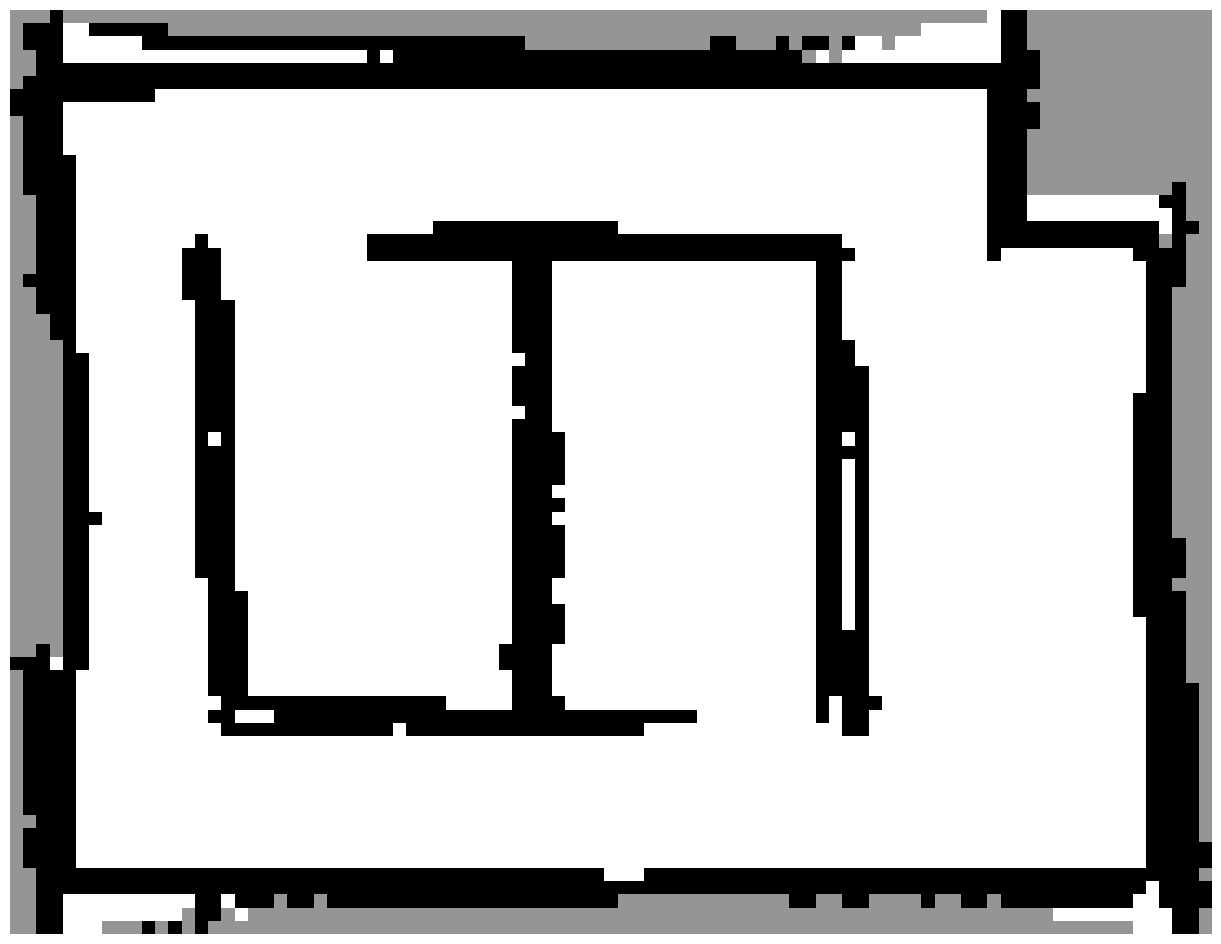

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
plt.imshow(map_room.T[::-1], cmap="Greys")
# plt.plot(shifted_pose[:, 0], shifted_pose[:, 1])
plt.xlabel("X, m")
plt.ylabel("Y, m")
plt.grid("off")
plt.axis("off")
plt.savefig("/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_pred.jpeg", bbox_inches='tight', pad_inches=0)
plt.show()

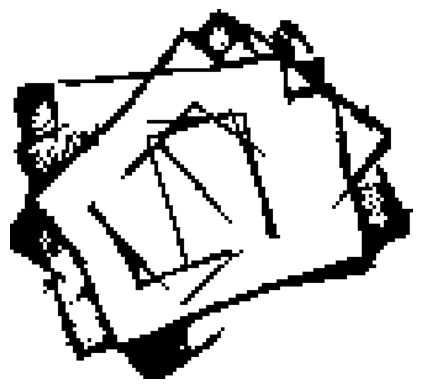

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


pred_image = Image.open('/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_odom.jpeg')

image_array = np.array(pred_image)
threshold = 100

for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
        r, g, b = image_array[i, j]
        if r > threshold and g > threshold and b > threshold:
            image_array[i, j] = [255, 255, 255]

result_image = Image.fromarray(image_array)
plt.imshow(result_image)
plt.axis("off")
plt.savefig("/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_raw_white.jpeg", bbox_inches='tight', pad_inches=0)

pred_image = Image.open('/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_pred.jpeg')

image_array = np.array(pred_image)
threshold = 100

for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
        r, g, b = image_array[i, j]
        if r > threshold and g > threshold and b > threshold:
            image_array[i, j] = [255, 255, 255]

result_image = Image.fromarray(image_array)
plt.imshow(result_image)
plt.axis("off")
plt.savefig("/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_pred_white.jpeg", bbox_inches='tight', pad_inches=0)

pred_image = Image.open('/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_plicp_pred.jpeg')
image_array = np.array(pred_image)
threshold = 100

for i in range(image_array.shape[0]):
    for j in range(image_array.shape[1]):
        r, g, b = image_array[i, j]
        if r > threshold and g > threshold and b > threshold:
            image_array[i, j] = [255, 255, 255]

result_image = Image.fromarray(image_array)
plt.imshow(result_image)
plt.axis("off")
plt.savefig("/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_plicp_pred_white.jpeg", bbox_inches='tight', pad_inches=0)

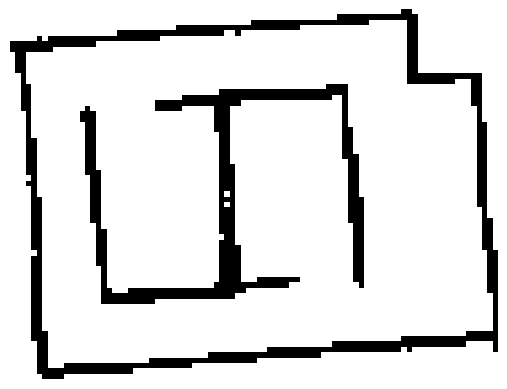

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the PGM image
# pred_image = Image.open('/content/drive/MyDrive/data/Skripsi/Proccessed/SLAM_TOOLBOX/22-05|12:56:08.pgm') #diamond
# pred_image = Image.open('/content/drive/MyDrive/data/Skripsi/Proccessed/SLAM_TOOLBOX/22-05|12:47:48.pgm') #diamond busuk
# pred_image = Image.open('/content/drive/MyDrive/data/Skripsi/Proccessed/SLAM_TOOLBOX/22-05|12:17:30.pgm') #rectangle
pred_image = Image.open('/content/drive/MyDrive/data/Skripsi/Proccessed/SLAM_TOOLBOX/21-05|14:53:48.pgm') #bounded room

# Convert the image to a numpy array
image_array = np.array(pred_image)

# Define the threshold
threshold = 100

image_array[image_array > threshold] = 255

result_image = Image.fromarray(image_array)

plt.imshow(result_image, cmap='gray')
plt.axis("off")
plt.savefig("/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_slam_toolbox_white.jpeg", bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

Image.MAX_IMAGE_PIXELS = None

# File paths
GT_file = "/content/drive/MyDrive/data/Skripsi/GT/room.jpeg"
odom_map = "/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_raw_white.jpeg"
plicp_map = "/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_plicp_pred_white.jpeg"
predicted_map = "/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_pred_white.jpeg"
slam_toolbox = "/content/drive/MyDrive/data/Skripsi/Proccessed/saveit/room_slam_toolbox_white.jpeg"

# Load images
gt_image = Image.open(GT_file).convert('L')
pred_image = Image.open(predicted_map).convert('L')
odom_image = Image.open(odom_map).convert('L')
plicp_image = Image.open(plicp_map).convert('L')
slam_image = Image.open(slam_toolbox).convert('L')

# Resize images
size = (gt_image.width//(gt_image.width// 428), gt_image.height//(gt_image.height//308))
gt_image = gt_image.resize(size, Image.Resampling.LANCZOS)

In [ ]:
def SSIM(ground_truth, predict):
    from skimage.metrics import structural_similarity as ssim
    # Maksimum piksel antara kedua input gambar
    final_size = (max(ground_truth.size[0], predict.size[0]), max(ground_truth.size[1], predict.size[1]))
    # Background berwarna putih untuk ground truth
    new_ground_truth_image = Image.new("L", final_size, 255)
    # Menentukan titik tengah dan meletakan piksel original ground truth
    ground_truth_paste_position = (
        (final_size[0] - ground_truth.size[0]) // 2,
        (final_size[1] - ground_truth.size[1]) // 2
    )
    new_ground_truth_image.paste(ground_truth, ground_truth_paste_position)

    # Background berwarna putih untuk gambar predict
    new_predict_image = Image.new("L", final_size, 255)
    # Menentukan titik tengah dan meletakan piksel original predict
    predict_paste_position = (
        (final_size[0] - predict.size[0]) // 2,
        (final_size[1] - predict.size[1]) // 2
    )
    new_predict_image.paste(predict, predict_paste_position)
    ssim_value = ssim(np.array(new_ground_truth_image), np.array(new_predict_image))
    return ssim_value

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def best_fit_transform(A, B):
    assert A.shape == B.shape
    m = A.shape[1]
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)
    t = centroid_B.T - np.dot(R,centroid_A.T)
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

def nearest_neighbor(src, dst):
    assert src.shape == dst.shape
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

def ICP_SVD(A, B, init_pose=None, max_iterations=30, tolerance=0.0001):
    assert A.shape == B.shape
    m = A.shape[1]
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)
    if init_pose is not None:
        src = np.dot(init_pose, src)
    prev_error = 0
    for i in range(max_iterations):
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)
        src = np.dot(T, src)
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances,

def ADNN(ground_truth, predict):
    import scipy
    import cv2
    predict_img = cv2.imread(predict, cv2.IMREAD_GRAYSCALE)
    _, binary_predict_img = cv2.threshold(predict_img, 128, 255, cv2.THRESH_BINARY)
    rows_pred, cols_pred = np.where(binary_predict_img == 0)
    points_pred = np.array([(cols_pred[i], rows_pred[i]) for i in range(len(rows_pred))])/100

    gt_img = cv2.imread(ground_truth, cv2.IMREAD_GRAYSCALE)
    new_width = gt_img.shape[1] // (gt_img.shape[1]// 428) # 428 : Panjang Peta GT(meter)
    new_height = gt_img.shape[0] // (gt_img.shape[0]// 308) # 308 : Lebar Peta GT(meter)
    gt_img = cv2.resize(gt_img, (new_width, new_height))
    _, binary_gt_img = cv2.threshold(gt_img, 128, 255, cv2.THRESH_BINARY)
    rows_gt, cols_gt = np.where(binary_gt_img == 0)
    points_gt = np.array([(cols_gt[i], rows_gt[i]) for i in range(len(rows_gt))])/100

    diff = abs(points_pred.shape[0] - points_gt.shape[0])
    mean = np.mean(points_gt)
    new_points = np.random.normal(loc=mean, scale=0, size=(diff, 2))
    added = np.vstack((points_gt, new_points))
    T, distances, = ICP_SVD(points_pred, added)
    points_after = T[:2, :2] @ np.array(points_pred).T + T[:2, 2].reshape(2, 1)
    return np.mean(distances), points_after, added

In [ ]:
from skimage.metrics import hausdorff_distance as hd, normalized_root_mse as nrmse, structural_similarity as ssim

In [ ]:
# hd_pred = hd(gt_image,pred_image)
SSIM_pred = SSIM(gt_image,pred_image)
adnn_pred, last_pred, added_pred = ADNN(GT_file, predicted_map)

# # hd_odom = hd(gt_image,odom_image)
SSIM_odom = SSIM(gt_image,odom_image)
adnn_odom, last_odom, added_odom = ADNN(GT_file,odom_map)

# # hd_slam = hd(gt_image,slam_image)
SSIM_slam = SSIM(gt_image,slam_image)
adnn_slam, last_slam, added_slam = ADNN(GT_file,slam_toolbox)

# # hd_plicp = hd(gt_image,plicp_image)
SSIM_plicp = SSIM(gt_image,plicp_image)
adnn_plicp, last_plicp, added_plicp = ADNN(GT_file,plicp_map)

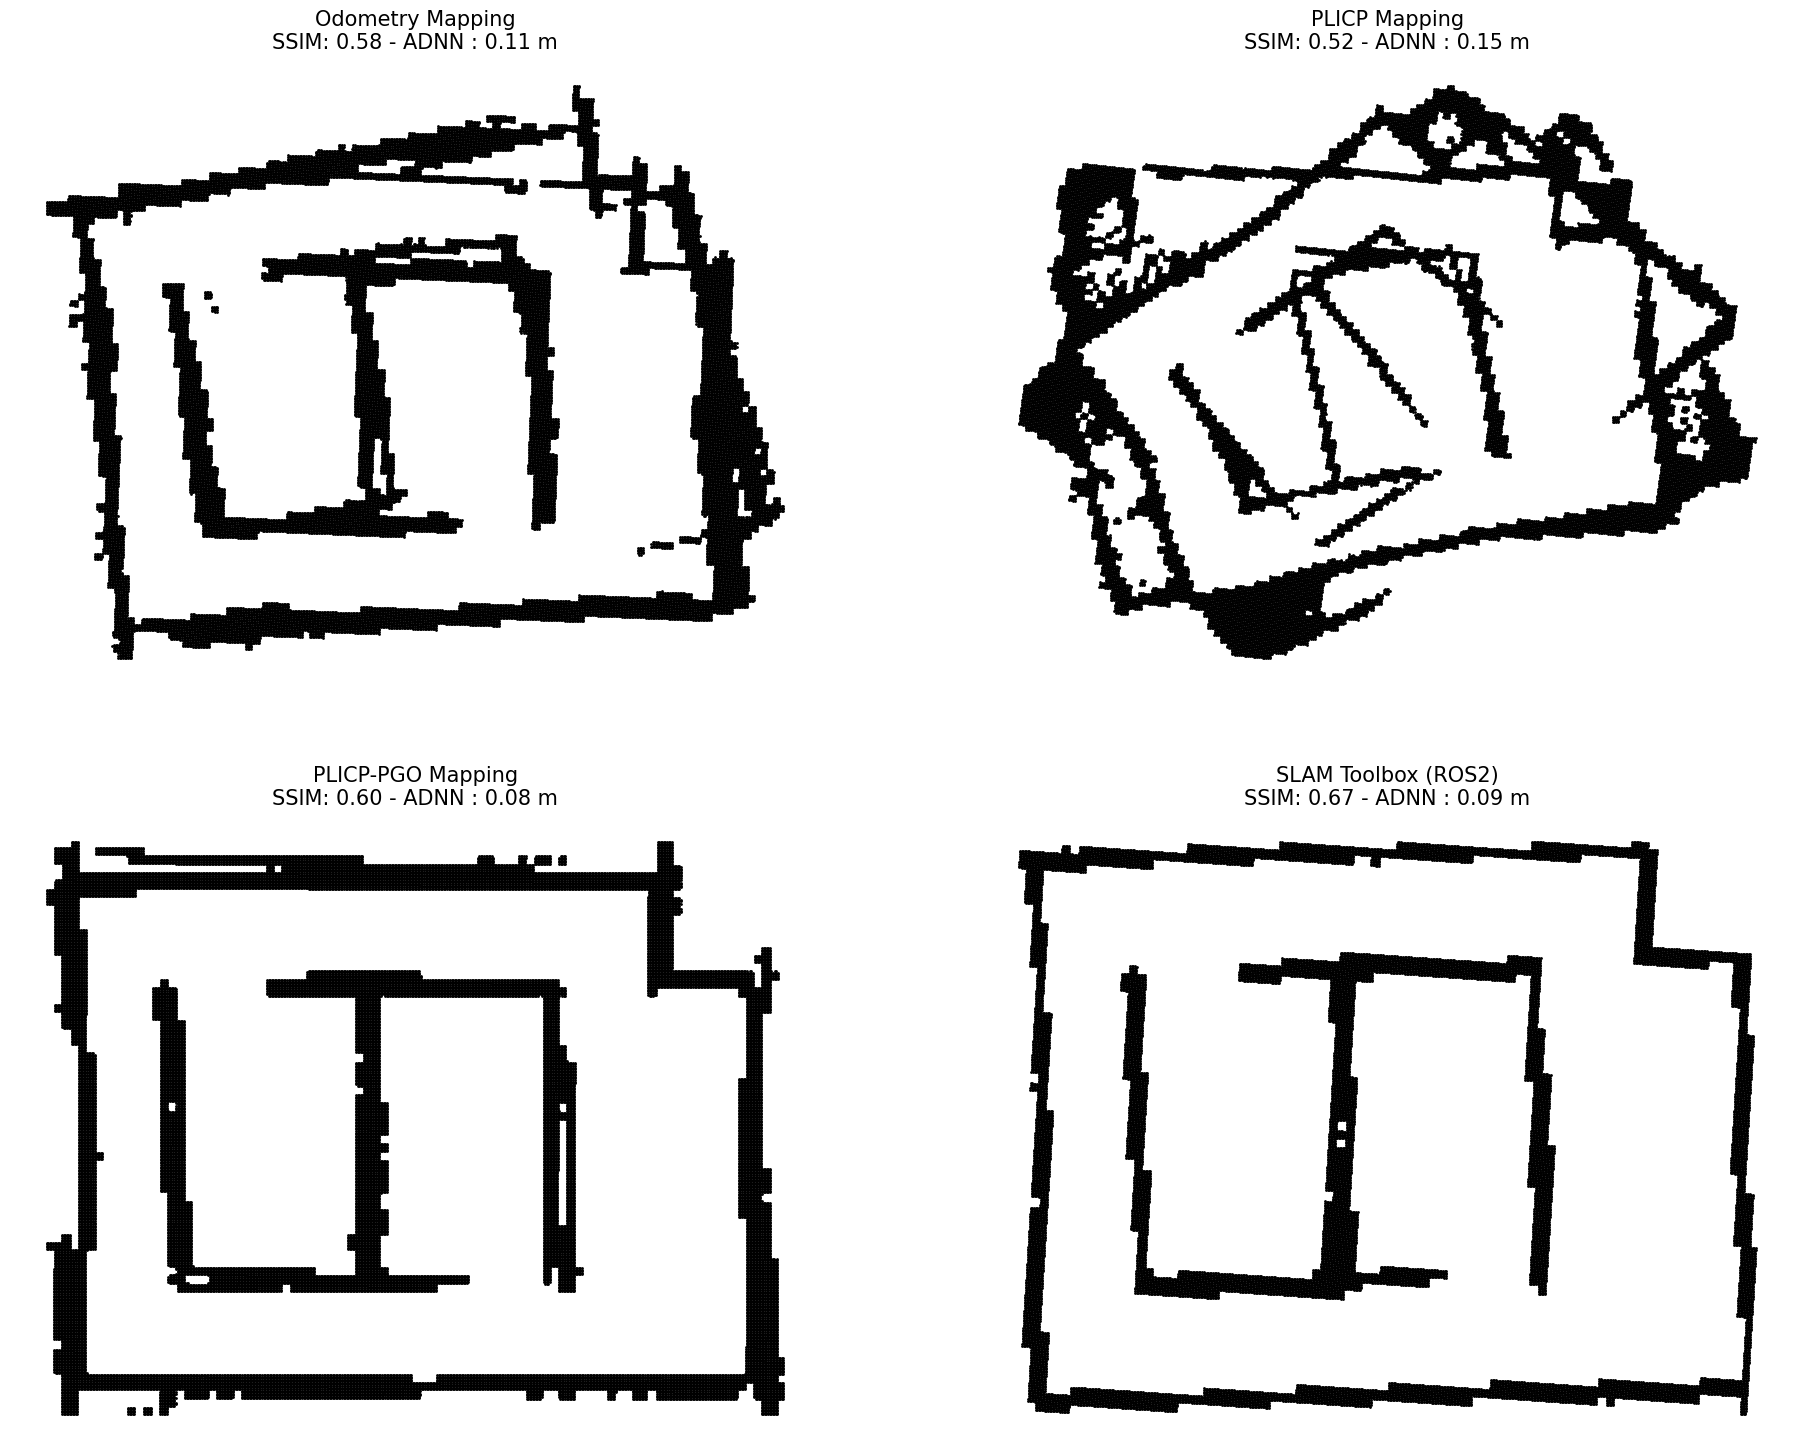

In [ ]:
# Titles
title_pred = f"SSIM: {SSIM_pred:.2f} - ADNN : {adnn_pred:.2f} m"
title_odom = f"SSIM: {SSIM_odom:.2f} - ADNN : {adnn_odom:.2f} m"
title_slam_toolbox = f"SSIM: {SSIM_slam:.2f} - ADNN : {adnn_slam:.2f} m"
title_plicp = f"SSIM: {SSIM_plicp:.2f} - ADNN : {adnn_plicp:.2f} m"

# Plot images
fig, axs = plt.subplots(2, 2, figsize=(23, 18))

# axs[0][0].scatter(added_odom.T[0], added_odom.T[1], s=1, c='gray')
axs[0][0].scatter(last_odom[0], last_odom[1], s=1, c='black')

# axs[0][1].scatter(added_plicp.T[0], added_plicp.T[1], s=1, c='gray')
axs[0][1].scatter(last_plicp[0], last_plicp[1], s=1, c='black')

# axs[1][0].scatter(added_pred.T[0], added_pred.T[1], s=1, c='gray')
axs[1][0].scatter(last_pred[0], last_pred[1], s=1, c='black')

# axs[1][1].scatter(added_slam.T[0], added_slam.T[1], s=1, c='gray')
axs[1][1].scatter(last_slam[0], last_slam[1], s=1, c='black')

axs[0][0].set_title(f'Odometry Mapping\n{title_odom}',fontsize=15)
axs[0][1].set_title(f'PLICP Mapping\n{title_plicp}', fontsize=15)
axs[1][0].set_title(f'PLICP-PGO Mapping\n{title_pred}',fontsize=15)
axs[1][1].set_title(f'SLAM Toolbox (ROS2)\n{title_slam_toolbox}', fontsize=15)

axs[0][0].axis("off")
axs[0][1].axis("off")
axs[1][0].axis("off")
axs[1][1].axis("off")

axs[0][0].invert_yaxis()
axs[0][1].invert_yaxis()
axs[1][0].invert_yaxis()
axs[1][1].invert_yaxis()

fig.show()

# +++++++++++++++++?????????++++++++++++++++++++++